## MNIST CNN

In [2]:
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

### Data

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
path.ls()

[PosixPath('/home/nihargajre/.fastai/data/mnist_png/testing'),
 PosixPath('/home/nihargajre/.fastai/data/mnist_png/training')]

In [6]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [7]:
il.items[0]

PosixPath('/home/nihargajre/.fastai/data/mnist_png/testing/0/9273.png')

In [8]:
defaults.cmap = 'binary'

In [9]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/nihargajre/.fastai/data/mnist_png

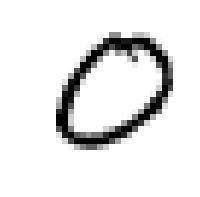

In [10]:
il[0].show()

In [11]:
sd = il.split_by_folder(train='training', valid='testing')

In [12]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/nihargajre/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/nihargajre/.fastai/data/mnist_png;

Test: None

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/nihargajre/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/nihargajre/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/nihargajre/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/nihargajre/.fastai/data/mnist_png;

Test: None

In [15]:
x, y = ll.train[0]

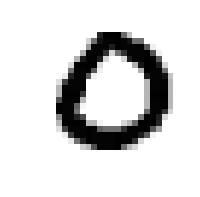

In [16]:
x.show()

In [17]:
print(y, x.shape)

0 torch.Size([1, 28, 28])


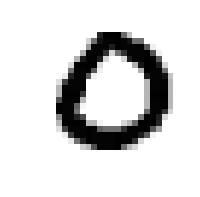

In [18]:
x.show()

In [19]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [20]:
tfms

([RandTransform(tfm=TfmPixel (pad), kwargs={'padding': 3, 'mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 28, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True)],
 [])

In [21]:
ll = ll.transform(tfms)

In [22]:
bs = 128

In [23]:
data = ll.databunch(bs=bs).normalize()

In [24]:
x, y = data.train_ds.__getitem__(1)

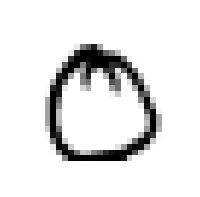

In [25]:
x.show()

In [26]:
print(y)

0


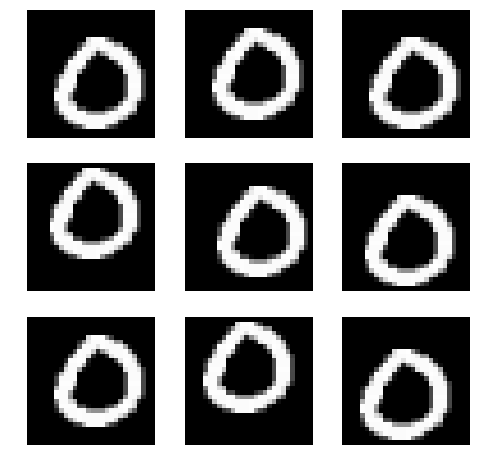

In [27]:
def _plot(i, j, ax):
    data.train_ds[0][0].show(ax, cmap='gray')

plot_multi(_plot, 3, 3, figsize=(8, 8))

In [28]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

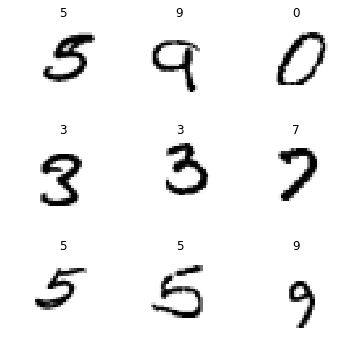

In [29]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with BatchNorm

In [32]:
def conv(in_channel, n_filters):
    return nn.Conv2d(in_channel, n_filters, kernel_size=3, stride=2,
                     padding=1)

In [33]:
model = nn.Sequential(
    conv(1, 8),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10),
    nn.BatchNorm2d(10),
    Flatten()
)

In [34]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(),
               metrics=accuracy)

In [35]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

In [36]:
xb = xb.cuda()

In [37]:
model(xb).shape

torch.Size([128, 10])

In [38]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


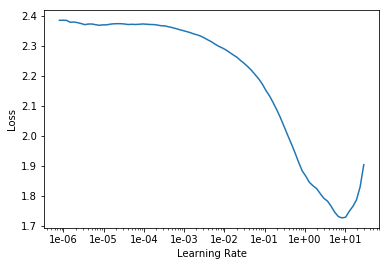

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.217852,0.142710,0.952700
2,0.140765,0.114690,0.966000
3,0.078238,0.047014,0.984300


### Refactor

In [41]:
def conv2(n_inputs, n_filters):
    return conv_layer(n_inputs, n_filters, stride=2)

In [47]:
model = nn.Sequential(
    conv2(1, 8),
    conv2(8, 16),
    conv2(16, 32),
    conv2(32, 16),
    conv2(16, 10),
    Flatten()
)

In [48]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [49]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.234511,0.150657,0.955100
2,0.180876,0.866393,0.754200
3,0.172009,0.158398,0.946400
4,0.134083,0.137995,0.955800
5,0.125063,0.107837,0.966800
6,0.098352,0.096395,0.969500
7,0.089576,0.053514,0.983200
8,0.061927,0.040431,0.987900
9,0.053622,0.033735,0.989700
10,0.049866,0.031251,0.991200


#### Aside: Without extra ReLU Layer

In [57]:
model = nn.Sequential(
    conv2(1, 8),
    conv2(8, 16),
    conv2(16, 32),
    conv2(32, 16),
    conv_layer(16, 10, stride=2, use_activ=False, norm_type=None),
    Flatten()
)

In [58]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(),
                metrics=accuracy)

In [59]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.234742,0.210766,0.929100
2,0.214386,0.289556,0.916300
3,0.188663,0.139438,0.954500
4,0.168007,0.151525,0.955000
5,0.138483,0.094828,0.971000
6,0.109006,0.060803,0.981100
7,0.077625,0.052762,0.984500
8,0.055495,0.034949,0.987400
9,0.042020,0.030546,0.989900
10,0.039167,0.028029,0.990300


* Does not have noticeable effect?
* Removing BN slightly reduced accuracy.

### Resnet-ish

In [60]:
class ResidualBlock(nn.Module):
    
    def __init__(self, n_filters):
        super().__init__()
        self.conv1 = conv_layer(n_filters, n_filters)
        self.conv2 = conv_layer(n_filters, n_filters)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

In [63]:
model = nn.Sequential(
    conv2(1, 8),
    ResidualBlock(8),
    conv2(8, 16),
    ResidualBlock(16),
    conv2(16, 32),
    ResidualBlock(32),
    conv2(32, 16),
    ResidualBlock(16),
    conv2(16, 10),
    Flatten()
)

In [64]:
def conv_and_res(ni, nf):
    return nn.Sequential(conv2(ni, nf), ResidualBlock(nf))

In [65]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [66]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(),
               metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


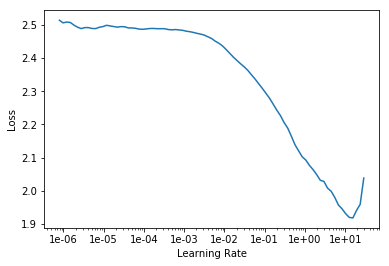

In [67]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.242415,0.175866,0.952800
2,0.131922,0.108796,0.967800
3,0.099326,0.151723,0.949200
4,0.081453,0.159148,0.946400
5,0.075527,0.148557,0.953400
6,0.054611,0.038743,0.987100
7,0.052789,0.041950,0.985700
8,0.045676,0.032548,0.989800
9,0.037104,0.026011,0.991600
10,0.031389,0.018815,0.994000


In [69]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________